# Week 5 Lab: The dark matter of the genome (ChIP-seq)

**Due: Monday 5/6/19 11:59pm**

Skills: ChIP-seq, genome browsers, peak calling, motif finding

## Intro
In 2006, there was a striking discovery that if you treat adult cells with a specific set of transcription factors, they could become "pluripotent", meaning they can then be programmed to theoretically any type of cell. These four transcription factors (Oct4/*Pou5f1*, Sox2, cMyc, and Klf4) are collectively known as "Yamanaka factors" (named after Shinya Yamanaka's lab, which originally showed this).

In this lab, we will analyze ChIP-sequencing from three of these factors (Oct4, Sox2, and Klf4) as well as two histone modifications (H3K4me2 and H3K27ac, which often mark regulatory/enhancer regions) in mouse embryonic stem cells, which are pluripotent and express the Yamanaka factors. We'll use the ChIP-seq data to determine where these factors and modifications are binding and which specific sequence motifs the factors are binding to.

In this lab, we'll go through:
1. Aligning ChIP-seq reads to a referenc genome
2. Visualizing ChIP-seq data in IGV.
3. Identifying binding sites from ChIP-seq data ("peak calling")
4. Visualizing patterns of transcription factor and histone modification binding.
5. Motif finding to identify the sequence a transcription factor binds to.

<font color="red">**FOR YOUR REPORT (Intro-Q1)**</font> In your own words, summarize background and motivation for the study. See the report notebook for more suggestions on how to write this.

<font color="red">**FOR YOUR REPORT (Intro-Q2)**</font> In your own words, summarize your main results. See the report notebook for more suggestions on how to write this. You should probably wait until you've actually completed the analyses to write this part though!


### Summary of tools covered
In this lab we'll be using the following tools:

* [BWA MEM](https://github.com/lh3/bwa): for aligning our reads to the reference genome
* [IGV](https://software.broadinstitute.org/software/igv/): a genome browser. Used for visualizing ChIP-seq alignments and peaks (and other types of genomic data)
* [HOMER](http://homer.ucsd.edu/homer/): a toolkit that supports a large number of analyses of ChIP-seq datasets (and was created right here at UCSD by Chris Benner!) These include:
  * Peak calling (identifying where the binding sites are from a ChIP-seq dataset)
  * Annotating peaks and generating coverage histogram plots
  * Motif finding (finding which sequences our transcription factor is binding to).

In the last part, you may also use:
* [MEME](http://meme-suite.org/): a suite of tools for motif analysis. Specifically, you'll probably use the `fimo` tool that is part of this package for scanning a genome for motif matches.
* [BEDtools](https://bedtools.readthedocs.io/en/latest/) a set of tools for wrangling BED files and other genomic data formats.

Note there are many tools available for performing these tasks. For a list of additional relevant tools see the lecture slides.

And as usual, we'll do some plotting examples with the [matplotlib](https://matplotlib.org/) Python library, but you can use whatever you're most comfortable with to plot. 


### Summary of data provided
Data for this week can be found in `/datasets/cs185s-sp19-public/week5`. You should see:

* `Oct4.esc.fastq`: reads from ChIP-seq of the transcription factor Oct4.
* `Klf4.esc.fastq`: reads from ChIP-seq of the transcription factor Klf4.
* `Sox2.esc.fastq`: reads from ChIP-seq of the transcription factor Sox2.
* `H3K27ac.esc.fastq`: reads from ChIP-seq of the histone modification H3K27ac.
* `H3K4me2.esc.fastq`: reads from ChIP-seq of the histone modification H3K4me2.
* `input.esc.fastq`: reads from an input control (whole cell extract) for the ChIP-seq. Recall this comes from performing ChIP-seq but without the antibody pull down step.

For the motif analysis in the last part, you'll also see:
* `GRCm38.chr17.fa`: chr17 extracted from the GRCm38 reference genome.
* `Oct4_motif.meme`: the MEME-format motif for Oct4.

Recall the mouse reference genome can be found at: `/datasets/cs185s-sp19-public/genomes/GRCm38.fa` (build GRCm38). For this week, we have also added the corresponding bwa index files in the same directory.

**Acknowledgements**: Parts of this lab are modified from material originally written by Chris Benner and revised by Alon Goren.

## Tips

You may include an image file (such as an IGV screenshot) by:
* saving the image on your local computer (png files should work)
* navigating in JupyterHub to the assignment directory.
* uploading the file
* Using HTML (e.g. `<img src=filename>`) to include the file in a markdown cell

Be aware of chromosome name mismatches. e.g. "chr17" vs. "17".

For long running commands, `nohup` is your friend.

# 1. Aligning ChIP-seq reads

Before getting started, it is always a good idea to get some basic stats on the data you're dealing with.

<font color="red">**FOR YOUR REPORT (Methods-Q1)**</font> Summarize the datasets we are starting with: what samples are we analyzing? Where did they come from? How many reads are there in each dataset, and what is the read length?

As in our previous NGS analyses, the first step here will be to align the reads to a reference genome. We recommend using `bwa mem`. Type the command at the terminal to see usage, or look back to Lab 1 to recall the syntax for running BWA. The genome at `/datasets/cs185s-sp19-public/genomes/GRCm38.fa` has already been indexed using `bwa index`.

Align reads from each dataset to the GRCm38 (mm10) reference genome. You may want to use UNIX for loops to avoid retyping the command many times (see example for loop below). You may also want to use multithreading (e.g. `-t 6` to speed this up, but make sure you're on the high memory instances if you do that.)

```shell
# Example for loop syntax. You will have to modify paths this to actually work on your data
for prefix in Oct4 Klf4 Sox2

do
    bwa mem GRCm38.fa ${prefix}.fastq | samtools view -bS > ${prefix}.bam
done

```

Store the results in `~/week5`. After aligning, use `samtools` to sort and index the resulting BAM file (again, look back to Lab 1 if you need a refresher how to do this).

After alignment finishes, it is a good practice to take a look at the resulting BAM files using `samtools view`. e.g.:

```shell
samtools view mysample.bam | less -S
```

You can also see how many reads aligned to each chromosome using e.g.:
```
samtools view ~/week5/bams/input.sorted.bam| cut -f 3 | uniq
```

(You should see that most reads were aligned to chr17, since we extracted only those reads to make this analysis run faster. But there will be reads aligned to other chromosomes as well which are mostly mapping errors).

<font color="red">**FOR YOUR REPORT (Methods-Q2)**</font> Summarize the methods you used to align the data. What aligner and version did you use? What build of the reference genome?

<font color="red">**FOR YOUR REPORT (Results-Q1)**</font> What percentage of your reads from each dataset were successfully aligned? Recall `samtools flagstat` can be used to easily find this number.

(Alignment might take a couple minutes. In the mean time, you might want to get started installing and exploring IGV in part 3).

# 2. Getting started with HOMER (making tag directories)

We will be using Homer for most of the analyses in this lab. For most analyses, Homer requires us to perform a preprocessing step to convert the BAM files into "tag directories". Tag directories are analogous to sorted BAM files and are the starting point for most HOMER operations like finding peaks, creating visualization files, or calculating read densities. The command also performs several quality control and parameter estimation calculations.

The command `makeTagDirectory` will do this for us. The syntax is:

```shell
makeTagDirectory <output directory> <input BAM file> [options]
```

For example, if you made a BAM file `~/week5/bams/Oct4.sorted.bam`, you might run:

```shell
makeTagDirectory ~/week5/tagdirs/Oct4 ~/week5/bams/Oct4.sorted.bam
```

This command is going through the BAM file and doing lots of preprocessing steps: removing reads that do not align to a unique position in the genome, separating reads by chromosome and sorting them by position, calculating how often reads appear in the same position to estimate the clonality (i.e. PCR duplication), calculating the relative distribution of reads relative to one another to estimate the ChIP-fragment length, calculating sequence properties and GC-content of the reads and performing a simple enrichment calculation to check if the experiment looks like a ChIP-seq experiment (vs. an RNA-seq experiment).

The command creates a new directory, in this case named `~/week5/tagdirs/Oct4`. Inside the directory are several test files that contain various QC results. Don't worry too much about those, but you can try looking at the output files by typing `less -S <filename>` to see what's there. 

Run this on all of your aligned BAM files. Again, we suggest using a bash for loop (see example syntax above) to avoid having to type the same command over and over again. It shouldn't take long (seconds) for each asmple to finish.

# 3. Visualizing the data with IGV

Next we will visualize the ChIP-seq experiments by creating [bedGraph files](https://genome.ucsc.edu/goldenPath/help/bedgraph.html) from the tag directories and using the IGV genome browser to look at the results. BedGraph files are similar to BED files we've seen in the past (with chrom, start, and end columns) except now with a 4th column giving a datavalue. These files are useful for describing how many reads aligned to each region of the genome.

We will create these files using the `makeUCSCfile` command that is part of Homer. For most ChIP-seq experiments all you need to do is specify the tag directory and specify `-o auto` for the command to automatically save the bedGraph file inside the tag directory. e.g.:

```shell
makeUCSCfile ~/week5/tagdirs/Oct4 -o auto
```

This creates the file `~/week5/tagdirs/Oct4/oct4-esc.ucsc.bedGraph.gz`. This file format specifies the normalized read depth at variable intervals along the genome (use `zcat` and the filename to view the file format for yourself).

Use the `makeUCSCfile` command to make bedGraph files for each of your samples. Again, you may find bash for loops helpful.

Now, to visualize with IGV, first download the bedGraph files to your local computer. You can download files from datahub by navigating to the directory where the file is stored, clicking the box next to it, and clicking "download".

Then, go to IGV. There is a [desktop version](https://software.broadinstitute.org/software/igv/download) and a javascript version (https://igv.org/app/). We *highly* recommend the desktop version, which can be easier to use and faster. Instructions below are the mostly the same regardless of which one you use.

Make sure to select the "mm10" genome (which is equivalent to GRCm38). Use "Tracks->Local file" to upload your bedgraph files.

The tracks will display the relative density (coverage) of ChIP-seq reads at each position in the genome. Zoom in chr17, since that is where all of data is from. 

See if there are any interesting patterns in the data that catch your eye. Try visiting the *Pou5f1* locus (the gene for Oct4) by typing the gene name into the search bar at the top. Once at the *Pou5f1* locus, zoom out to see if there any nearby sites with possible binding sites in each of your tracks.

<font color="red">**FOR YOUR REPORT (Results-Q2)**</font> Based on visual inspection of the datasets on IGV, where are the peaks for each of the datasets falling (promoters? gene regions? exons? elsewhere?). How do the signals for the transcripton factors (Oct4, Sox2, and Klf4) compare to the signals for the two histone modifications? What does the input signal look like? You may wish to include a screenshot of the IGV visualization in your report. The lecture slides provide some hints for the types of patterns you should be seeing for each dataset.

## 4. Identifying binding sites (peaks)

One of the most common tasks with ChIP-seq data is to find regions that enriched (compared to a control like whole cell extract). These enriched regions are commonly called "peaks". We will use the `findPeaks` utility from Homer, which takes tag directories as input and outputs a set of peak regions.

The general syntax of the command is:

```shell
findPeaks <tag directory> -i <control tag directory> -style XX -o auto
```

for example:
```shell
findPeaks ~/week5/tagdirs/Oct4 -i ~/week5/tagdirs/input -style factor -o auto
```

where we will use `-style factor` for transcription factors and `style histone` for histone modifications. Generally, for transcription factors we will be looking for more focal, narrower peaks whereas for histone modifications we will be looking for broader peaks. This flag tells Homer which type of peaks to look for.

This command will look for enriched regions and filter them based on several criteria, including ensuring that they have at least 4-fold more reads in peak regions relative to the control experiment (in this case `input`). The output will be stored in a HOMER-style peak file located in the Oct4 tag directory (`Oct4/peaks.txt`). This file will be called `regions.txt`, rather than `peaks.txt`, for histone modifications. The beginning of this file contains statistics and QC stats from the peak finding, including the number of peaks, number of peaks lost to input filtering, etc. 

One field worth paying attention to is the "Approximate IP efficiency" which reports what fraction of reads from the experiment were actually found in peaks. For most decent experiments this value ranges from 1% to >30% (remember ChIP is an enrichment strategy... there is plenty of background in the data too!). 

After the header lines (which begin with `#`, you'll see the actual peaks, with one line per peak. There are a lot of columns. The important ones for us are: columns 2-4 give the chromosome start end, column 11 gives the fold change over the background, and column 12 gives the p-value.

Use `findPeaks` to call peaks in each sample. Be sure to set `style` appropriately for each dataset.

<font color="red">**FOR YOUR REPORT (Methods-Q3)**</font> Summarize the methods you used to call peaks for each sample the data. What tool did you use? Which version? Did you use any non-default parameters? Did you use a different command for transcription factors vs. histone modifications?

<font color="red">**FOR YOUR REPORT (Results-Q3)**</font> Summarize peak-finding results: what was the IP efficiency reported for each dataset? How many peaks did you find? What was the average peak size for each dataset? Note you should only have 5 peak sets, since you won't have peaks for the input control.

One other thing to note is that HOMER reports the results in a "peak" file, which has a slightly different format from a traditional BED file format. To create a BED file from the peak file, use the Homer utility `pos2bed.pl` following the sample below. BED files can be uploaded to IGV just like a bedGraph file. Also, most HOMER programs will work with either BED or peak files as input. Example command:
```
pos2bed.pl Oct4/peaks.txt > Oct4/Oct4.peaks.bed`
```

Copy the peaks (in BED format) you called to your local computer, and upload the resulting files to IGV. Explore how they look on IGV: what does the coverage profile look like for peaks with high scores? low scores?


## 5. Visualizing binding patterns

We will next use the Homer utility `annotatePeaks.pl` to learn about where our peaks are falling. This tool can do a lot of different things. For now we'll use it to visualize read counts around promoter regions.

The general usage of `annotatePeaks.pl` is:
```shell
annotatePeaks.pl <peaks file> <genome fasta> [options] > output.txt
```

We can use the `-hist` option to `annotatePeaks.pl`, which gives the relative count of reads for each dataset centered around a specific feature. Here, we will look at read counts relative to transcription start sites (TSSs), which mark the center of promoter regions. The command below can be used to create histogram data for a list of tag directories. Note you'll have to change this command if your tag directories had different names.

```shell
annotatePeaks.pl tss \
  /datasets/cs185s-sp19-public/genomes/GRCm38.fa \
  -size 8000 \
  -hist 10 \
  -d ~/week5/tagdirs/Oct4 ~/week5/tagdirs/Sox2 ~/week5/tagdirs/Klf4 ~/week5/tagdirs/H3K4me2 ~/week5/tagdirs/H3K27ac \
  -gtf /datasets/cs185s-sp19-public/genomes/GRCm38.75.gtf > ~/week5/annotations/tss_histogram.txt
```

Here is a brief description of the options used:
* `tss` is a built in shortcut telling Homer to look at regions centered on transcription start sites. We could have also provided a peaks file with regions to plot or a BED file listing locations of transcription start sites.
* `GRCm38.fa` tells it where the reference genome is
* `-size 8000` tells it look at 8000bp regions centered at each TSS
* `-hist 10` gives the bin size for our histograms
* `-d tagdir1 tagdir2...` gives a list of tag directories
* `-gtf` points it to the gene annotations, which it needs to figure out where the TSSs are.

Take a look at the output file. You’ll notice that the first column gives the distance offsets from the TSS followed by columns corresponding to the ‘coverage’, ‘+ Tags’, and ‘- Tags’ for each experiment. The code in the cell below shows how to load this histogram to a pandas dataframe and plot the distribution of Oct4 and H2K27ac around TSSs. You may hear these types of plots referred to as "composite plots".

<font color="red">**FOR YOUR REPORT (Methods-Q4)**</font> Summarize the methods you used to annotate peaks for each sample the data and visualize read counts around transcription start sites. What tool did you use? Which version? 

<font color="red">**FOR YOUR REPORT (Results-Q4)**</font>: Generate a composite plot showing the distribution of all five datasets around TSSs. Be sure to label your axes and provide a legend or description of which color denotes which dataset.

Populating the interactive namespace from numpy and matplotlib


,dist.from.tss,Oct4,Sox2,Klf4,H3K4me2,H3K27ac
0,-4000,0.894853,0.816687,0.929456,1.465848,1.165416
1,-3990,0.890395,0.807531,0.927906,1.467393,1.170515
2,-3980,0.881561,0.804261,0.920969,1.469015,1.171071
3,-3970,0.888774,0.802299,0.920071,1.469324,1.171164
4,-3960,0.882209,0.792080,0.915256,1.482844,1.179044


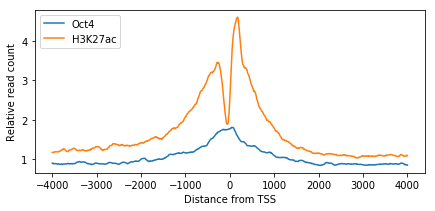

In [1]:
%pylab inline
import pandas as pd

data = pd.read_csv("~/week5/annotations/tss_histogram.txt", sep="\t")

# Reset column headers to make them easier to deal with
marks = ["Oct4","Sox2","Klf4","H3K4me2","H3K27ac"]

colnames = ["dist.from.tss"]
for m in marks: colnames.extend(["%s"%m,"%s:+"%m,"%s:-"%m])
data.columns = colnames
data = data[["dist.from.tss"]+marks]

# Peek at the dataframe
display(data.head())

fig = plt.figure()
fig.set_size_inches((7, 3))
ax = fig.add_subplot(111)
ax.plot(data["dist.from.tss"], data["Oct4"], label="Oct4");
ax.plot(data["dist.from.tss"], data["H3K27ac"], label="H3K27ac");
ax.set_xlabel("Distance from TSS")
ax.set_ylabel("Relative read count")
ax.legend(loc="upper left");

## 6. Motif finding

Now that we have an idea where these factors are binding, we'd like to know what type of sequences they bind to. Motif finding is a powerful technique to identify specific patterns of DNA sequence that are bound by a particular transcription factor. To use HOMER’s motif analysis program, run the findMotifsGenome.pl command using peak files from the experiments. In general the command has syntax:

```shell
findMotifsGenome.pl <peaks> <refgenome> <output directory> [options]
```

For example:

```shell
prefix=Oct4
findMotifsGenome.pl \
 ~/week5/tagdirs/${prefix}/peaks.txt \
 /datasets/cs185s-sp19-public/genomes/GRCm38.fa \
 ~/week5/motifs/${prefix} \
 -mask -size 100
```
This will find motifs enriched in Oct4 peaks, and output the results to the directory `~/week5/motifs/Oct4`. The options at the end tell it to mask repeats when performing the analysis, and to look at regions of size 100 centered at each peak region.

This will create, among other things, a file `~/week5/motifs/Oct4/homerResults.html` containing motifs that Homr found to be significantly enriched in our set of peaks. Navigate through Jupyter to view this html file in your browser.

Run motif finding for the three transcription factors (don't do this for the histone modifications, which aren't likely to give good motifs since they do not recognize specific sequences like transcription factors do. of course if you really want to try it go ahead). This can take a while. You can speed it up with e.g. `-p 5` to use multithreading. Or use `nohup` to run it in the background and come back to it later.

<font color="red">**FOR YOUR REPORT (Results-Q5)**</font> Which motifs did you find to be most enriched for each factor? How do these compare to published logos for these factors? It can be helpful to include a figure comparing them.

See: http://hocomoco11.autosome.ru/mouse/mono?full=false for published motifs for many mouse factors, including Klf4, Pou5f1/Oct4, and Sox2).

<font color="red">**FOR YOUR REPORT (Methods-Q5)**</font> Summarize the methods you used to perform motif finding in each transcription factor. What tool did you use? Which version? Where did you get known motifs for comparison?

## 7. Differential binding

You might have noticed a strong similarity between the motifs of Sox2 and Oct4! On IGV you'll see these often bind together. In this section, we'll see if we can find a motif that is specific to Sox2 binding, rather than Sox2+Oct4 binding.

First, merge the peak sets from the two factors so you just have one set of regions to analyze. You can use the Homer `mergePeaks` command for this. e.g.:

```shell
mergePeaks ~/week5/tagdirs/Oct4/peaks.txt ~/week5/tagdirs/Sox2/peaks.txt > ~/week5/overlap/oct4_sox2_peaks_merged.txt
```

Now, you can compare read counts from Oct4 vs. Sox2 in these merged regions. The `annotatePeaks.pl` tool can help us get these read counts:\. e.g.:
```shell
annotatePeaks.pl \
   ~/week5/overlap/oct4_sox2_peaks_merged.txt \
  /datasets/cs185s-sp19-public/genomes/GRCm38.fa \
  -d ~/week5/tagdirs/Oct4 ~/week5/tagdirs/Sox2 > ~/week5/overlap/oct4_sox2_scatter.txt
```

Take a look at the output file (`oct4_sox2_scatter.txt`) above. The last two columns should have normalized tag counts for Oct4 and Sox2.

<font color="red">**FOR YOUR REPORT (Results-Q6)**</font> Make a scatter plot comparing normalized read counts for Oct4 vs. Sox2 that you got from the merged peak set. Highlight peaks (using a different color) that correspond to peaks with two-fold higher binding in Sox2 vs. Oct4.

<font color="red">**FOR YOUR REPORT (Results-Q7)**</font> Repeat motif finding, but this time using only the peaks that were unique to Sox2 (fold change >2). Report the motif you found. Is this different than the motif you found when analyzing *all* Sox2 peaks? Does this match to published motifs for Sox2?

<font color="red">**FOR YOUR REPORT (Methods-Q6)**</font> Summarize the methods you used to analyze peaks specific to Sox2 (and not Oct4). What tools did you use? How did you extract Sox2-specific peaks?

## 8. To bind or not to bind (challenge question)

***Note: in this section we are leaving it up to you to figure out how to use these tools! You'll likely need to do some data wrangling along the way with some of the UNIX commands we learned to get this to work.***

Hopefully you were able to characterize the sequence patterns (motifs) that your TFs are likely to bind to. It's worth noting however that just because a TF's motif exists somewhere in the genome, does not necessarily mean it will bind! (This is for many reasons. For instance, some regions of the genome are condensed and not open to allow TF binding). In fact, we're likely to find many matches to these motifs in the genome just by chance, even if the genome was just a bunch of random nucleotides, and the vast majority of those will not actually be bound by our TF.

As an example, let's look at the motif for Oct4. We'd like to explore: (1) how many times the Oct4 motif occurs on chr17 and (2) what percentage of those occurrences are actually bound? (i.e., overlap a peak in our ChIP-seq data?).

To help you out with this, we have included the following files in the `week5` directory which you may find helpful:

* `GRCm38.chr17.fa`: the genome sequence of only chr17 for the GRCm38 assembly. Useful since we only are analyzing chr17, so should be faster to analyze this than the whole genome fasta file.
* `OCT4_motif.meme`: the Oct4 motif in [MEME format](http://meme-suite.org/).

You may also find these tools helpful (already available on datahub):
* `fimo` can be used to scan a genome for matches to a specific motif. The files listed above can be used as input.
* `intersectBed` can be used to intersect sets of genomic regions.

Remember, you almost always just type the name of a command to get a help message about how you should use it and what the options are.

<font color="red">**FOR YOUR REPORT (Methods-Q7)**</font> Summarize the methods you used to scan chr17 for matches to the Oct4 motif and overlap with ChIP-seq peaks for Oct4.

<font color="red">**FOR YOUR REPORT (Results-Q8)**</font> How many instances of the Oct4 motif did you find on chr17? How many of those were actually bound (i.e. overlapped a peak in our ChIP-seq data?

## Discussion

**<font color="red">FOR YOUR REPORT: See questions Q1-Q3 in the report</font>**. Specific prompts for each question are given in the report notebook.

## References

To read more about the data used for this lab see: https://www.ncbi.nlm.nih.gov/pubmed/28111071

<font color="red">**FOR YOUR REPORT (References-Q1)**</font> Provide at least 2 works that you cite in your report. For example, you will likely reference Homer and the paper by Chronis et al. where the data is taken from.